<a href="https://colab.research.google.com/github/forcodingakp/4_bit_CPU_with_assembler/blob/master/food_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Grain-surface = 0 m, positive downward.
DEPTHS_M = {          # <— update if you know the exact probe depths
    "S1": 0.10, "S2": 0.45, "S3": 0.80,  "S4": 1.15,
    "S5": 1.50, "S6": 1.85, "S7": 2.20,  "S8": 2.55,
    "S9": 2.90, "S10": 3.25,"S11": 3.60
}


In [ ]:
import pandas as pd, numpy as np, sys, textwrap
from pathlib import Path

# ------------------------------------------------------------------
FILE_PATH = '/content/Miryalaguda_data.CSV'          # uses the file you just uploaded

# Column names we EXPECT in the CSV
sensor_ids = [f"S{i}" for i in range(1, 12)]
COLS = ["Timestamp"] + [f"{sid}_T" for sid in sensor_ids] + [f"{sid}_H" for sid in sensor_ids]

# ---- read the file (the first line in your CSV is a broken header) ----
df = pd.read_csv(FILE_PATH, header=None, names=COLS, skiprows=1)

# timestamp → pandas datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%d-%m-%Y %H:%M")

# Convert sensor data columns to numeric, coercing errors
for sid in sensor_ids:
    df[f"{sid}_T"] = pd.to_numeric(df[f"{sid}_T"], errors='coerce')
    df[f"{sid}_H"] = pd.to_numeric(df[f"{sid}_H"], errors='coerce')

# ------------------------------------------------------------------
#  MODEL SETTINGS  – edit if you have better property data
HEIGHT = 4.572      # m  (15 ft grain depth)
NODES  = 41         # vertical grid points  (~11 cm layers)
ALPHA  = 1.7e-7     # thermal diffusivity   (m² s⁻¹)
D_EFF  = 2.0e-7     # moisture diffusivity  (m² s⁻¹)
DT     = 60.0       # time step (s)  (stable for FTCS with 11 cm dx)

# Linearised Henderson-type isotherm around 30 °C
a_iso, b_iso = 0.00181818, 0.00363636
def M_from_RH(T, RH):  return a_iso*RH + b_iso + 0.0005*(T-30)
def RH_from_M(T, M):   return (M - b_iso - 0.0005*(T-30))/a_iso

SAVE_EVERY = 6*3600    # record profiles every 6 h

# ------------------------------------------------------------------
#  BUILD INITIAL PROFILES
z_nodes = np.linspace(0, HEIGHT, NODES)
depth_array = np.array([DEPTHS_M[s] for s in sensor_ids])

row0 = df.iloc[0]

# Explicitly convert to numeric before extracting values
T0_sensor  = pd.to_numeric(row0[[f"{s}_T" for s in sensor_ids]], errors='coerce').to_numpy()
RH0_sensor = pd.to_numeric(row0[[f"{s}_H" for s in sensor_ids]], errors='coerce').to_numpy()

T          = np.interp(z_nodes, depth_array, T0_sensor)   # °C
M          = M_from_RH(T, np.interp(z_nodes, depth_array, RH0_sensor))

# ------------------------------------------------------------------
#  SURFACE (top) TEMPERATURE DRIVER
top_id = min(DEPTHS_M, key=DEPTHS_M.get)                  # shallowest probe
surf_series = df[["Timestamp", f"{top_id}_T"]].copy()
surf_series["h"] = (surf_series["Timestamp"]-surf_series["Timestamp"].iloc[0]).dt.total_seconds()/3600
t_surf = surf_series["h"].to_numpy()
T_surf = surf_series[f"{top_id}_T"].to_numpy()
Tsurf  = lambda t_sec: np.interp(t_sec/3600, t_surf, T_surf,
                                 left=T_surf[0], right=T_surf[-1])

# ------------------------------------------------------------------
#  MAIN SOLVER (explicit FTCS)
dx       = HEIGHT / (NODES-1)
steps    = int(np.ceil((df["Timestamp"].iloc[-1]-df["Timestamp"].iloc[0]).total_seconds()/DT))

rec_time, rec_T, rec_RH = [0], [T.copy()], [RH_from_M(T, M)]

for n in range(1, steps+1):
    t = n*DT
    # interior nodes
    T[1:-1] += ALPHA*DT/dx**2 * (T[2:] - 2*T[1:-1] + T[:-2])
    M[1:-1] += D_EFF*DT/dx**2 * (M[2:] - 2*M[1:-1] + M[:-2])
    # boundaries
    T[0]  = Tsurf(t)
    M[0]  = M[1]          # no moisture flux
    T[-1] = T[-2]         # insulated floor
    M[-1] = M[-2]
    # record every 6 h
    if n % int(SAVE_EVERY/DT) == 0:
        rec_time.append(t/3600)
        rec_T.append(T.copy())
        rec_RH.append(RH_from_M(T, M))

# ------------------------------------------------------------------
#  SAVE RESULTS
out = pd.DataFrame({"Hour": rec_time})
for j, z in enumerate(z_nodes):
    out[f"T_{z:.2f}m"]  = [row[j] for row in rec_T]
    out[f"RH_{z:.2f}m"] = [row[j] for row in rec_RH]

out.to_csv("simulated_T_RH_profiles.csv", index=False)
print("✅  Model finished – CSV written to  /content/simulated_T_RH_profiles.csv")
out.head()

✅  Model finished – CSV written to  /content/simulated_T_RH_profiles.csv


,Hour,T_0.00m,RH_0.00m,T_0.11m,RH_0.11m,T_0.23m,RH_0.23m,T_0.34m,RH_0.34m,T_0.46m,...,T_4.11m,RH_4.11m,T_4.23m,RH_4.23m,T_4.34m,RH_4.34m,T_4.46m,RH_4.46m,T_4.57m,RH_4.57m
0,0.0,32.2,69.900000,33.613657,68.408714,44.913029,56.488857,56.212400,44.569000,66.038857,...,32.500000,74.200000,32.500000,74.200000,32.500000,74.200000,32.500000,74.200000,32.500000,74.200000
1,6.0,32.1,66.315052,35.745510,65.312536,45.090824,56.191288,55.302165,45.689519,61.183172,...,32.500064,74.199887,32.500003,74.199994,32.500000,74.200000,32.500000,74.200000,32.500000,74.200000
2,12.0,32.2,64.384787,37.008513,63.062445,45.285477,55.751971,54.000435,47.205812,57.990575,...,32.501416,74.197633,32.500126,74.199760,32.500010,74.199979,32.500001,74.199998,32.500001,74.199998
3,18.0,32.3,62.888339,37.773891,61.383018,45.323453,55.409881,52.711010,48.596900,55.704808,...,32.507505,74.188003,32.500978,74.198230,32.500111,74.199771,32.500012,74.199971,32.500012,74.199971
4,24.0,32.2,61.778617,38.197250,60.129372,45.204258,55.186836,51.544672,49.757374,53.987333,...,32.522466,74.165473,32.503802,74.193422,32.500565,74.198892,32.500083,74.199812,32.500083,74.199812


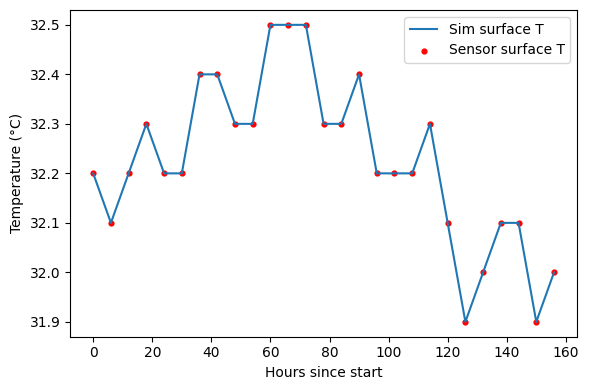

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(out["Hour"], out["T_0.00m"], label="Sim surface T")
plt.scatter(t_surf, T_surf, s=12, c="r", label="Sensor surface T")
plt.xlabel("Hours since start"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.tight_layout()


In [ ]:
import pandas as pd, numpy as np

# ---------- constants (same as used in the report) ----------
HEIGHT = 4.572               # m
AREA   = 9.144 * 6.096       # m²  (30 ft × 20 ft)
NODES  = 41                  # must match solver grid
rho_b  = 550                 # kg m⁻³  bulk density rough rice
c_p    = 1600                # J kg⁻¹ K⁻¹
a_iso, b_iso = 0.00181818, 0.00363636
def M_from_RH(T,RH): return a_iso*RH + b_iso + 0.0005*(T-30)

# ---------- load simulation output ----------
sim = pd.read_csv("/content/simulated_T_RH_profiles.csv")
z   = np.linspace(0, HEIGHT, NODES)           # depths that match the column order

# ---------- helper to convert one row to arrays ----------
def row_to_profiles(row):
    T = row.filter(like="T_").values
    RH = row.filter(like="RH_").values
    M = M_from_RH(T, RH)
    return T, M

# ---------- loop over 24-h blocks ----------
day_results = []
for d in range(6):
    row1 = sim.iloc[d*4]       # 0,24,48,… hours  (every 6 h → 4 rows/day)
    row2 = sim.iloc[(d+1)*4]
    T1,M1 = row_to_profiles(row1)
    T2,M2 = row_to_profiles(row2)

    dH = np.trapz(rho_b*c_p*(T2-T1), z)        # J per m²
    dW = np.trapz(rho_b*(M2-M1), z)            # kg water per m²
    day_results.append([d+1, dH/1e6, dH/1e6*AREA, dW, dW*AREA])

daily = pd.DataFrame(day_results,
                     columns=["Day","ΔH MJ/m²","ΔH MJ bin","ΔW kg/m²","ΔW kg bin"])
print(daily)


   Day  ΔH MJ/m²  ΔH MJ bin  ΔW kg/m²  ΔW kg bin
0    1 -0.504170 -28.103379 -0.464030 -25.865894
1    2 -0.683064 -38.075215 -0.142541  -7.945498
2    3 -0.625615 -34.872907 -0.053235  -2.967431
3    4 -0.585772 -32.652013 -0.024714  -1.377584
4    5 -0.516649 -28.798957 -0.016723  -0.932194
5    6 -0.471689 -26.292828 -0.015045  -0.838623


/tmp/ipython-input-8-3935492376.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dH = np.trapz(rho_b*c_p*(T2-T1), z)        # J per m²
/tmp/ipython-input-8-3935492376.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dW = np.trapz(rho_b*(M2-M1), z)            # kg water per m²


the below is the implementation for stack Latest implementation


In [ ]:
#!/usr/bin/env python3
# ================================================================
#  Grain-room diagonal monitor : heat / moisture flux + hot/cold
# ================================================================
import pandas as pd, numpy as np, math

# ----------------------------------------------------------------
# 1· user inputs
FILE_PATH = "/content/Miryalaguda_data.CSV.csv"   #  <-  adjust if needed

# Probe co-ordinates (m) from front-left-bottom corner
coords = {
    "S1":  (0.75, 0.75, 0.75),
    "S2":  (0.75, 1.25, 1.75),
    "S3":  (0.75, 1.75, 2.75),
    "S4":  (0.75, 2.25, 3.75),
    "S5":  (1.55, 1.25, 1.25),
    "S6":  (1.55, 1.75, 2.25),
    "S7":  (1.55, 2.25, 3.25),
    "S8":  (2.25, 1.75, 1.75),
    "S9":  (2.25, 2.25, 2.75),
    "S10": (2.25, 2.75, 3.75),
    "S11": (4.50, 0.75, 4.50)   # wall probe
}

# Physical constants
k_eff  = 0.15       # W m⁻¹ K⁻¹    (bagged paddy)
rho_b  = 550        # kg m⁻³
c_p    = 1600       # J kg⁻¹ K⁻¹
D_eff  = 2e-7       # m² s⁻¹
a_iso, b_iso = 0.00181818, 0.00363636   # linear sorption fit

# Hot/cold threshold (°C deviation from mean)
THRESH = 1.0
# ----------------------------------------------------------------

def M_from_RH(T, RH):
    return a_iso*RH + b_iso + 0.0005*(T-30)

# ---------- read the cleaned CSV ----------
df = pd.read_csv(FILE_PATH)
df["Timestamp"] = pd.to_datetime(
    df["Timestamp"],
    format="mixed",      # tell Pandas "each row may differ"
    dayfirst=True,       # so 13-06-2025 is 13 June, not 6 Jan
    errors="coerce"      # un-parsable rows → NaT, we’ll flag later
)
df.sort_values("Timestamp", inplace=True); df.reset_index(drop=True, inplace=True)

probe_ids = list(coords.keys())

# ---------- order probes along the diagonal (by x+y+z) ----------
ordered = sorted(probe_ids, key=lambda p: sum(coords[p]))
s = [0.0]                       # cumulative distance list
for p_prev, p_next in zip(ordered, ordered[1:]):
    x1,y1,z1 = coords[p_prev]
    x2,y2,z2 = coords[p_next]
    s.append(s[-1] + math.dist((x1,y1,z1), (x2,y2,z2)))
s = np.array(s)                 # m

# ---------- storage for outputs ----------
flux_rows, flag_rows = [], []

for _, row in df.iterrows():
    # pull values in diagonal order
    T  = np.array([row[f"{pid}T"] for pid in ordered], dtype=float)
    RH = np.array([row[f"{pid}H"] for pid in ordered], dtype=float)
    M  = M_from_RH(T, RH)

    # finite-difference gradients along diagonal
    dT_ds = np.gradient(T, s)
    dM_ds = np.gradient(M, s)

    # heat & moisture flux (per m² cross-section reference)
    q  = -k_eff         * dT_ds                 # W m⁻²
    Jw = -rho_b*D_eff   * dM_ds                 # kg m⁻² s⁻¹

    # integrate along the diagonal
    Q_tot = np.trapz(q,  s)                     # W m⁻²
    W_tot = np.trapz(Jw, s)                     # kg m⁻² s⁻¹
    flux_rows.append([row["Timestamp"], Q_tot, W_tot])

    # hot / cold labelling
    meanT = T.mean()
    flags = ["HOT"    if t >= meanT + THRESH
             else "COLD"  if t <= meanT - THRESH
             else "NORMAL" for t in T]
    flag_rows.append([row["Timestamp"]] + flags)

# ---------- write outputs ----------
flux_df = pd.DataFrame(flux_rows, columns=["Timestamp","HeatFlux_Wpm2","WaterFlux_kgpm2s"])
flag_df = pd.DataFrame(flag_rows, columns=["Timestamp"] + ordered)

flux_df.to_csv("diagonal_fluxes.csv", index=False)
flag_df.to_csv("hot_cold_flags.csv", index=False)

print("✅  diagonal_fluxes.csv   (heat & water flux vs. time)")
print("✅  hot_cold_flags.csv    (HOT/COLD/NORMAL per probe)")
print("\nFirst few HOT/COLD rows:")
print(flag_df.head().to_string(index=False))


✅  diagonal_fluxes.csv   (heat & water flux vs. time)
✅  hot_cold_flags.csv    (HOT/COLD/NORMAL per probe)

First few HOT/COLD rows:
          Timestamp     S1     S2     S5     S3     S6     S8   S4     S7     S9    S10    S11
2025-06-12 00:00:00 NORMAL   COLD NORMAL NORMAL NORMAL NORMAL COLD NORMAL NORMAL NORMAL NORMAL
2025-06-12 06:00:00 NORMAL   COLD NORMAL NORMAL NORMAL NORMAL COLD    HOT    HOT NORMAL NORMAL
2025-06-12 12:00:00 NORMAL    HOT NORMAL NORMAL NORMAL NORMAL COLD NORMAL NORMAL NORMAL NORMAL
2025-06-12 18:00:00 NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL COLD NORMAL NORMAL NORMAL NORMAL
2025-06-13 00:00:00 NORMAL   COLD NORMAL NORMAL NORMAL NORMAL COLD NORMAL NORMAL NORMAL    HOT


/tmp/ipython-input-12-187218583.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Q_tot = np.trapz(q,  s)                     # W m⁻²
/tmp/ipython-input-12-187218583.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  W_tot = np.trapz(Jw, s)                     # kg m⁻² s⁻¹


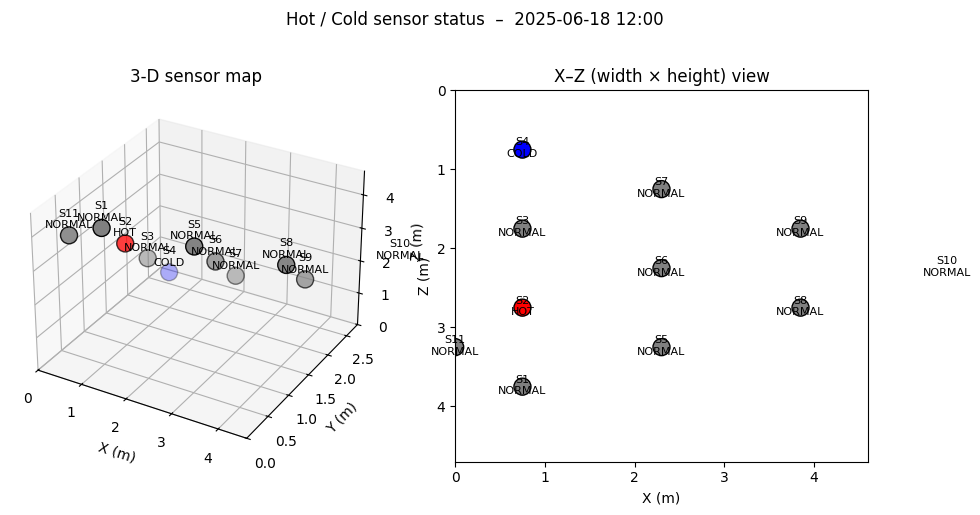

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === USER-EDITABLE SETTINGS =====================================
FLAG_FILE   = "/content/hot_cold_flags.csv"      # output from diagonal script
TIMESTAMP   = None                      # e.g. "2025-06-14 06:00"; leave None = latest row
# colour palette
COLOURS     = {"HOT":"red", "COLD":"blue", "NORMAL":"grey"}
# ==============================================================

# probe 3-D coordinates (metres) – must match those in the solver
coords = {
    "S1":  (0.75, 0.75, 4.50-0.75),
    "S2":  (0.75, 1.25, 4.50-1.75),
    "S3":  (0.75, 1.75, 4.50-2.75),
    "S4":  (0.75, 2.25, 4.50-3.75),
    "S5":  (2.30, 1.25, 4.50-1.25),
    "S6":  (2.30, 1.75, 4.50-2.25),
    "S7":  (2.30, 2.25, 4.50-3.25),
    "S8":  (3.85, 1.75, 4.50-1.75),
    "S9":  (3.85, 2.25, 4.50-2.75),
    "S10": (5.48, 2.75, 4.50-2.25),
    "S11": (0.00, 0.75, 4.50-1.25)
}

# ----------------------------------------------------------------
flags = pd.read_csv(FLAG_FILE, parse_dates=["Timestamp"])

# select row
if TIMESTAMP is None:
    row = flags.iloc[-1]       # latest
    ts  = row["Timestamp"]
else:
    ts  = pd.to_datetime(TIMESTAMP)
    row = flags.loc[flags["Timestamp"]==ts].squeeze()
    if row.empty:
        raise ValueError(f"Timestamp {TIMESTAMP} not found in file.")

# build scatter arrays
xs, ys, zs, colours, labels = [], [], [], [], []
for pid,(x,y,z) in coords.items():
    xs.append(x); ys.append(y); zs.append(z)
    status = row[pid]
    colours.append(COLOURS.get(status,"grey"))
    labels.append(f"{pid}\n{status}")

# ----------------------------------------------------------------
# ( unchanged lines above … we already have xs, ys, zs, colours, labels )
# ----------------------------------------------------------------

fig = plt.figure(figsize=(10,5))

# --- 1) 3-D scatter -------------------------------------------------
ax3d = fig.add_subplot(1, 2, 1, projection='3d')
ax3d.scatter(xs, ys, zs, s=150, c=colours, edgecolor='k', depthshade=True)

for x, y, z, label in zip(xs, ys, zs, labels):
    ax3d.text(x, y, z+0.15, label, ha='center', va='bottom', fontsize=8)

ax3d.set_xlabel("X (m)")
ax3d.set_ylabel("Y (m)")
ax3d.set_zlabel("Z (m)")
ax3d.set_xlim(0, 4.6); ax3d.set_ylim(0, 2.8); ax3d.set_zlim(0, 4.7)
ax3d.set_title("3-D sensor map")

# --- 2) 2-D X–Z projection -----------------------------------------
ax2d = fig.add_subplot(1, 2, 2)
ax2d.scatter(xs, zs, s=150, c=colours, edgecolor='k')

for x, z, label in zip(xs, zs, labels):
    ax2d.text(x, z+0.12, label, ha='center', va='bottom', fontsize=8)

ax2d.set_xlabel("X (m)")
ax2d.set_ylabel("Z (m)")
ax2d.set_xlim(0, 4.6); ax2d.set_ylim(0, 4.7)
ax2d.invert_yaxis()            # optional: put floor at bottom of plot
ax2d.set_title("X–Z (width × height) view")

fig.suptitle(ts.strftime("Hot / Cold sensor status  –  %Y-%m-%d %H:%M"), y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# import pandas as pd, numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import griddata

# # ============== EDIT THESE TWO LINES ============================
# CSV_FILE  = "/content/Miryalaguda_data.CSV.csv"   # cleaned header version
# TIMESTAMP = None                              # e.g. "2025-06-14 06:00"; None = latest
# # ================================================================

# # Probe co-ordinates (m)  —— same as used in the solver
# coords = {
#     "S1":  (0.75, 0.75, 4.50-0.75),
#     "S2":  (0.75, 1.25, 4.50-1.75),
#     "S3":  (0.75, 1.75, 4.50-2.75),
#     "S4":  (0.75, 2.25, 4.50-3.75),
#     "S5":  (2.30, 1.25, 4.50-1.25),
#     "S6":  (2.30, 1.75, 4.50-2.25),
#     "S7":  (2.30, 2.25, 4.50-3.25),
#     "S8":  (3.85, 1.75, 4.50-1.75),
#     "S9":  (3.85, 2.25, 4.50-2.75),
#     "S10": (5.48, 2.75, 4.50-2.25),
#     "S11": (0.00, 0.75, 4.50-1.25)
# }

# probe_ids = list(coords.keys())

# # --------- helper to convert RH→moisture, but we only need RH here
# # if your CSV has "S1H" column = RH already (0-100 %)
# # ---------------------------------------------------------------
# df = pd.read_csv(CSV_FILE)
# df["Timestamp"] = pd.to_datetime(
#     df["Timestamp"],
#     format="mixed",      # tell Pandas "each row may differ"
#     dayfirst=True,       # so 13-06-2025 is 13 June, not 6 Jan
#     errors="coerce"      # un-parsable rows → NaT, we’ll flag later
# )
# df.sort_values("Timestamp", inplace=True)

# # choose row
# if TIMESTAMP is None:
#     row = df.iloc[-1]
#     ts_label = row["Timestamp"]
# else:
#     ts_label = pd.to_datetime(TIMESTAMP)
#     row = df.loc[df["Timestamp"] == ts_label].squeeze()
#     if row.empty:
#         raise ValueError("Timestamp not found in file.")

# # build sample arrays
# x, z, rh = [], [], []
# for pid in probe_ids:
#     xi, yi, zi = coords[pid]
#     x.append(xi)            # length direction
#     z.append(zi)            # height
#     rh.append(row[f"{pid}H"])   # RH %

# x, z, rh = np.array(x), np.array(z), np.array(rh)

# # create grid
# xi = np.linspace(0, 9.144, 200)   # length 30 ft
# zi = np.linspace(0, 4.572, 100)   # height 15 ft
# X, Z = np.meshgrid(xi, zi)

# # interpolate RH onto grid (inverse distance weight via 'linear')
# RH_grid = griddata((x, z), rh, (X, Z), method='linear')
# # mask extrapolated NaNs
# RH_grid_masked = np.ma.masked_invalid(RH_grid)

# # ------------ PLOT ---------------------------------------------
# fig, ax = plt.subplots(figsize=(8, 3.2))

# c = ax.contourf(X, Z, RH_grid_masked, levels=np.linspace(50,100,26),
#                 cmap="jet", extend='both')
# ax.set_title(f"Relative Humidity cloud map  –  {ts_label.strftime('%Y-%m-%d %H:%M')}")
# ax.set_xlabel("Length of grain pile (m)")
# ax.set_ylabel("Height of grain pile (m)")
# cb = fig.colorbar(c, ax=ax, label="Humidity %")
# ax.scatter(x, z, c='k', s=20, label="Sensor")
# ax.legend(frameon=False, loc="upper right")

# plt.tight_layout()
# plt.show()


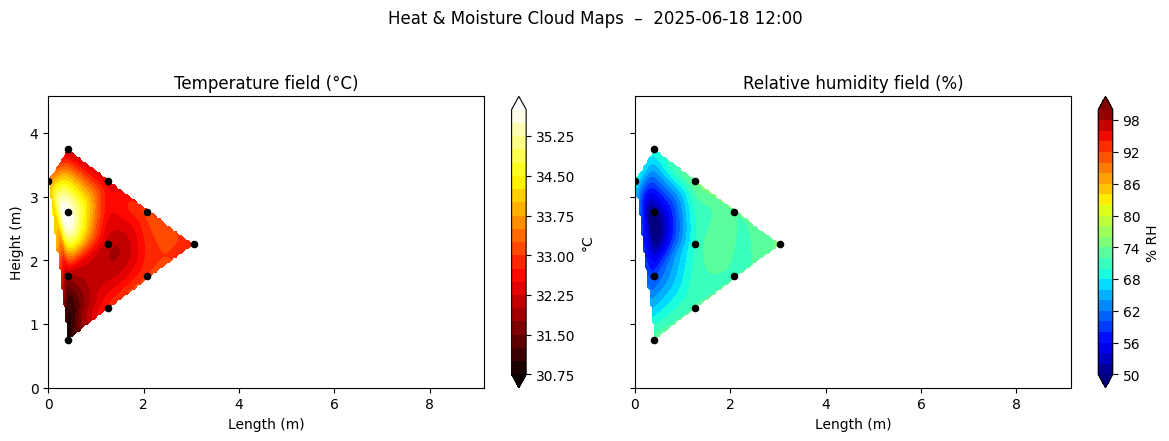

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# -----------------------------------------------------------------
# USER SETTINGS – change only these if paths / timestamp differ
CSV_FILE  = "/content/Miryalaguda_data.CSV.csv"    # <-- your cleaned data
TIMESTAMP = None                                   # None = most recent row
# -----------------------------------------------------------------

# probe coordinates (m) — must match the physical room layout
coords = {                              # metres from front-left-bottom
    "S1":(0.41,0.63,3.75),"S2":(0.41,0.63,2.75),"S3":(0.41,0.63,1.75),
    "S4":(0.41,0.63,0.75),"S5":(1.26,1.92,3.25),"S6":(1.26,1.92,2.25),
    "S7":(1.26,1.92,1.25),"S8":(2.08,3.24,2.75),"S9":(2.08,3.24,1.75),
    "S10":(3.05,4.55,2.25),"S11":(0.0,0.0,3.25)
}
probe_ids = list(coords.keys())

# read & sort csv
df = pd.read_csv(CSV_FILE)
df["Timestamp"] = pd.to_datetime(
    df["Timestamp"],
    format="mixed",      # tell Pandas "each row may differ"
    dayfirst=True,       # so 13-06-2025 is 13 June, not 6 Jan
    errors="coerce"      # un-parsable rows → NaT, we’ll flag later
)
df.sort_values("Timestamp", inplace=True)

# pick the row
if TIMESTAMP is None:
    row = df.iloc[-1]
    ts_label = row["Timestamp"]
else:
    ts_label = pd.to_datetime(TIMESTAMP)
    row = df.loc[df["Timestamp"] == ts_label].squeeze()
    if row.empty:
        raise ValueError("Timestamp not found in file.")

# build arrays for interpolation
x, z, T, RH = [], [], [], []
for pid in probe_ids:
    xi, yi, zi = coords[pid]        # we use x (length) & z (height)
    x.append(xi); z.append(zi)
    T.append(row[f"{pid}T"])
    RH.append(row[f"{pid}H"])

x, z, T, RH = map(np.array, (x, z, T, RH))

# target grid (XOZ plane at the average Y of probes)
xi = np.linspace(0, 9.144, 200)    # room length (m)
zi = np.linspace(0, 4.572, 120)    # room height (m)
X, Z = np.meshgrid(xi, zi)

# interpolated fields
T_grid  = griddata((x, z), T,  (X, Z), method='cubic')
RH_grid = griddata((x, z), RH, (X, Z), method='cubic')

# plotting -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4.2), sharey=True)

# ---- Temperature (heat) map ----
cf1 = axes[0].contourf(X, Z, T_grid, levels=20, cmap="hot", extend='both')
axes[0].scatter(x, z, c='k', s=20)
axes[0].set_title("Temperature field (°C)")
axes[0].set_xlabel("Length (m)")
axes[0].set_ylabel("Height (m)")
fig.colorbar(cf1, ax=axes[0], label="°C")

# ---- Relative-humidity cloud map ----
cf2 = axes[1].contourf(X, Z, RH_grid, levels=np.linspace(50, 100, 26),
                       cmap="jet", extend='both')
axes[1].scatter(x, z, c='k', s=20)
axes[1].set_title("Relative humidity field (%)")
axes[1].set_xlabel("Length (m)")
fig.colorbar(cf2, ax=axes[1], label="% RH")

fig.suptitle(f"Heat & Moisture Cloud Maps  –  {ts_label.strftime('%Y-%m-%d %H:%M')}", y=1.04)
plt.tight_layout()
plt.show()


In [ ]:
'''
the code which uses only the first hour and the last hour of the day (not utlises all the 4 hours in the data set)
'''


# # ---------------------------------------------------------------
# #  DAILY TOTAL HEAT & WATER TRANSFER FROM 3-D SENSOR NETWORK
# # ---------------------------------------------------------------
# import pandas as pd, numpy as np
# from scipy.spatial import Delaunay

# FILE = "/content/Miryalaguda_data.CSV.csv"        # cleaned header: Timestamp, S1T, S1H, …
# probe_xyz = {          # metres from front-left-bottom
#     "S1":(0.75,0.75,0.75),"S2":(0.75,1.25,1.75),"S3":(0.75,1.75,2.75),
#     "S4":(0.75,2.25,3.75),"S5":(1.55,1.25,1.25),"S6":(1.55,1.75,2.25),
#     "S7":(1.55,2.25,3.25),"S8":(2.25,1.75,1.75),"S9":(2.25,2.25,2.75),
#     "S10":(2.25,2.75,3.75),"S11":(4.50,0.75,4.50)
# }

# rho_b, c_p = 550, 1600
# a_iso, b_iso = 0.00181818, 0.00363636
# def M_from_RH(T,RH): return a_iso*RH + b_iso + 0.0005*(T-30)

# df = pd.read_csv(FILE)
# df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True, errors="raise")
# df.sort_values("Timestamp", inplace=True)

# probes = list(probe_xyz.keys())
# pts = np.array([probe_xyz[p] for p in probes])
# tri = Delaunay(pts)                         # tetrahedral mesh
# tet_vol = abs(np.linalg.det(pts[tri.simplices][:,1:]-pts[tri.simplices][:,:1]))/6

# daily_results = []

# for date, dayframe in df.groupby(df["Timestamp"].dt.date):
#     if len(dayframe) < 2:
#         continue                          # need at least start & end rows
#     start, end = dayframe.iloc[0], dayframe.iloc[-1]

#     # arrays of T and RH at start & end (ordered by probes list)
#     Ts = start[[f"{p}T" for p in probes]].to_numpy(float)
#     Rs = start[[f"{p}H" for p in probes]].to_numpy(float)
#     Te = end  [[f"{p}T" for p in probes]].to_numpy(float)
#     Re = end  [[f"{p}H" for p in probes]].to_numpy(float)

#     Ms, Me = M_from_RH(Ts,Rs), M_from_RH(Te,Re)

#     # interpolate field values at tetra vertices
#     dT = Te - Ts
#     dM = Me - Ms
#     dH_J = np.sum(tet_vol * rho_b * c_p *
#                   dT[tri.simplices].mean(axis=1))
#     dW_kg = np.sum(tet_vol * rho_b *
#                    dM[tri.simplices].mean(axis=1))

#     daily_results.append([date, dH_J/1e6, dW_kg])

# daily = pd.DataFrame(daily_results,
#                      columns=["Date","ΔH_MJ","ΔW_kg"])
# daily.to_csv("daily_heat_mass_transfer.csv", index=False)
# print(daily)


In [ ]:
#!/usr/bin/env python3
# =================================================================
#  DAILY HEAT- & MOISTURE-BALANCE  — integrates every 6-h interval
# =================================================================
import pandas as pd, numpy as np
from scipy.spatial import Delaunay

# ---------- 1. USER INPUTS ---------------------------------------
CSV = "/content/Miryalaguda_data.CSV.csv"      # cleaned header: Timestamp,S1T,S1H,…
probe_xyz = {                              # metres from front-left-bottom
    "S1":(0.41,0.63,3.75),"S2":(0.41,0.63,2.75),"S3":(0.41,0.63,1.75),
    "S4":(0.41,0.63,0.75),"S5":(1.26,1.92,3.25),"S6":(1.26,1.92,2.25),
    "S7":(1.26,1.92,1.25),"S8":(2.08,3.24,2.75),"S9":(2.08,3.24,1.75),
    "S10":(3.05,4.55,2.25),"S11":(0.0,0.0,3.25)
}
# physical data
rho_b, c_p = 550, 1600      # kg m⁻³ , J kg⁻¹ K⁻¹
a_iso, b_iso = 0.00181818, 0.00363636
M_from_RH = lambda T,RH: a_iso*RH + b_iso + 0.0005*(T-30)
# -----------------------------------------------------------------

# ---------- 2. READ & PREP DATA ---------------------------------
df = pd.read_csv(CSV)
df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True, errors="raise")
df.sort_values("Timestamp", inplace=True); df.reset_index(drop=True, inplace=True)

probes = list(probe_xyz)
pts = np.array([probe_xyz[p] for p in probes])

# ---------- 3. ONE-TIME DELAUNAY TESSELLATION --------------------
tri = Delaunay(pts)
# tetra volumes: |det(B)|/6 where B = x2−x1,… (vectorised)
B = pts[tri.simplices][:,1:] - pts[tri.simplices][:,:1]
tet_vol = np.abs(np.linalg.det(B))/6          # shape (n_tets,)

# helper: given arrays T, M per probe → ΔH_J, ΔW_kg for the whole bin
def volume_integral(dT, dM):
    # mean ΔT, ΔM in each tet
    dT_mean = dT[tri.simplices].mean(axis=1)
    dM_mean = dM[tri.simplices].mean(axis=1)
    dH_J  = np.sum(tet_vol * rho_b * c_p * dT_mean)
    dW_kg = np.sum(tet_vol * rho_b       * dM_mean)
    return dH_J, dW_kg

# ---------- 4. LOOP OVER 6-HOUR INTERVALS -----------------------
daily = {}   # date → [ΔH_J, ΔW_kg]

for i in range(1, len(df)):
    t_prev, t_now = df.iloc[i-1], df.iloc[i]

    T_prev = t_prev[[f"{p}T" for p in probes]].to_numpy(float)
    RH_prev= t_prev[[f"{p}H" for p in probes]].to_numpy(float)
    T_now  = t_now [[f"{p}T" for p in probes]].to_numpy(float)
    RH_now = t_now [[f"{p}H" for p in probes]].to_numpy(float)

    dT = T_now - T_prev
    dM = M_from_RH(T_now, RH_now) - M_from_RH(T_prev, RH_prev)

    dH_J, dW_kg = volume_integral(dT, dM)     # per 6-h slice

    key = t_now["Timestamp"].date()           # credit to the day that ENDS the slice
    daily.setdefault(key, [0.0, 0.0])
    daily[key][0] += dH_J
    daily[key][1] += dW_kg

# ---------- 5. WRITE DAILY LEDGER --------------------------------
out = (pd.DataFrame([(k, v[0]/1e6, v[1]) for k,v in sorted(daily.items())],
                    columns=["Date","ΔH_MJ","ΔW_kg"]))
out.to_csv("Miryalaguda_heat_mass_transfer_fullsum.csv", index=False)
print(out)


         Date     ΔH_MJ     ΔW_kg
0  2025-06-12  0.064449 -0.280583
1  2025-06-13 -0.007140  0.359428
2  2025-06-14  0.045050 -0.402868
3  2025-06-15 -0.031245 -0.125318
4  2025-06-16 -0.013059 -0.106228
5  2025-06-17 -0.005089 -0.157666
6  2025-06-18 -0.003314 -0.092929


In [ ]:
#!/usr/bin/env python3
# =================================================================
#  DAILY HEAT- & MOISTURE-BALANCE  — integrates every 6-h interval
# =================================================================
import pandas as pd, numpy as np
from scipy.spatial import Delaunay

# ---------- 1. USER INPUTS ---------------------------------------
CSV = "/content/nalgonda_data.csv"      # cleaned header: Timestamp,S1T,S1H,…
probe_xyz = {                              # metres from front-left-bottom
    "S1":(0.41,0.63,3.75),"S2":(0.41,0.63,2.75),"S3":(0.41,0.63,1.75),
    "S4":(0.41,0.63,0.75),"S5":(1.26,1.92,3.25),"S6":(1.26,1.92,2.25),
    "S7":(1.26,1.92,1.25),"S8":(2.08,3.24,2.75),"S9":(2.08,3.24,1.75),
    "S10":(3.05,4.55,2.25),"S11":(0.0,0.0,3.25)
}
# physical data
rho_b, c_p = 550, 1600      # kg m⁻³ , J kg⁻¹ K⁻¹
a_iso, b_iso = 0.00181818, 0.00363636
M_from_RH = lambda T,RH: a_iso*RH + b_iso + 0.0005*(T-30)
# -----------------------------------------------------------------

# ---------- 2. READ & PREP DATA ---------------------------------
df = pd.read_csv(CSV)
df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True, errors="raise")
df.sort_values("Timestamp", inplace=True); df.reset_index(drop=True, inplace=True)

probes = list(probe_xyz)
pts = np.array([probe_xyz[p] for p in probes])

# ---------- 3. ONE-TIME DELAUNAY TESSELLATION --------------------
tri = Delaunay(pts)
# tetra volumes: |det(B)|/6 where B = x2−x1,… (vectorised)
B = pts[tri.simplices][:,1:] - pts[tri.simplices][:,:1]
tet_vol = np.abs(np.linalg.det(B))/6          # shape (n_tets,)

# helper: given arrays T, M per probe → ΔH_J, ΔW_kg for the whole bin
def volume_integral(dT, dM):
    # mean ΔT, ΔM in each tet
    dT_mean = dT[tri.simplices].mean(axis=1)
    dM_mean = dM[tri.simplices].mean(axis=1)
    dH_J  = np.sum(tet_vol * rho_b * c_p * dT_mean)
    dW_kg = np.sum(tet_vol * rho_b       * dM_mean)
    return dH_J, dW_kg

# ---------- 4. LOOP OVER 6-HOUR INTERVALS -----------------------
daily = {}   # date → [ΔH_J, ΔW_kg]

for i in range(1, len(df)):
    t_prev, t_now = df.iloc[i-1], df.iloc[i]

    T_prev = t_prev[[f"{p}T" for p in probes]].to_numpy(float)
    RH_prev= t_prev[[f"{p}H" for p in probes]].to_numpy(float)
    T_now  = t_now [[f"{p}T" for p in probes]].to_numpy(float)
    RH_now = t_now [[f"{p}H" for p in probes]].to_numpy(float)

    dT = T_now - T_prev
    dM = M_from_RH(T_now, RH_now) - M_from_RH(T_prev, RH_prev)

    dH_J, dW_kg = volume_integral(dT, dM)     # per 6-h slice

    key = t_now["Timestamp"].date()           # credit to the day that ENDS the slice
    daily.setdefault(key, [0.0, 0.0])
    daily[key][0] += dH_J
    daily[key][1] += dW_kg

# ---------- 5. WRITE DAILY LEDGER --------------------------------
out = (pd.DataFrame([(k, v[0]/1e6, v[1]) for k,v in sorted(daily.items())],
                    columns=["Date","ΔH_MJ","ΔW_kg"]))
out.to_csv("Nalgonda_heat_mass_transfer_fullsum.csv", index=False)
print(out)


         Date     ΔH_MJ     ΔW_kg
0  2025-06-15 -0.019497 -0.103039
1  2025-06-16 -0.036821 -0.074925
2  2025-06-17 -0.030825 -0.179071
3  2025-06-18 -0.026799 -0.039123
